In [8]:
#For documentation on using this program refer to: https://github.com/RohanPankaj/NBA-Prediction/blob/master/docs/Team-Prediction.md

In [9]:
#imports
import pandas as pd 
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time
import matplotlib.pyplot as plt
import math
from datetime import datetime

import nba_api
from nba_api.stats.static import teams, players
from nba_api.stats.endpoints import playercareerstats, leaguegamefinder, playerdashboardbyclutch, playergamelogs, commonplayerinfo, teamplayeronoffdetails, teamgamelogs


In [10]:
class Team(object):
    def __init__(self, team_abbreviation):
        
        try:
            self.team_abbreviation = team_abbreviation
            print("confirmed", self.team_abbreviation)
        except:
            print(self.team_abbreviation, " is not a valid team abbreviation")
        self.TeamID =  int(teams.find_team_by_abbreviation(self.team_abbreviation)["id"])
        self.TeamName = teams.find_team_name_by_id(team_id=self.TeamID)['full_name']
        self.StartYear = datetime.now().year - 1 #First year data is avalible
        self.LastYear = datetime.now().year #Current year
        
        
    #Complile the Team Data
    def compile_active_team_data(self):
    
        # Lists for the data feilds. Later these will be combined into a DataFrame
        team_season_point_average_raw_data = []
        team_points_raw_data = []
        opponent_season_point_average_raw_data = []
        opponent_season_points_raw_data = []
        
        team_season_FT_average_specific_raw_data = []
        team_season_FG_average_specific_raw_data = []
        team_season_FG3_average_specific_raw_data = []
        
        team_season_FTA_average_specific_raw_data = []
        team_season_FGA_average_specific_raw_data = []
        team_season_FG3A_average_specific_raw_data = []
        
        opponent_season_FT_average_raw_data = []
        opponent_season_FG_average_raw_data = []
        opponent_season_FG3_average_raw_data = []
        
        game_duration = []
        
        
        print("-------------------------------------------------")
        self.season = str(self.StartYear) + "-" + str(((self.LastYear)-2000)) #format the season correctly for the API

        teamLogs_current_regular = teamgamelogs.TeamGameLogs(team_id_nullable=self.TeamID, season_nullable=self.season).get_data_frames()[0]
        teamLogs_current_playoffs = teamgamelogs.TeamGameLogs(team_id_nullable=self.TeamID, season_nullable=self.season, season_type_nullable="Playoffs").get_data_frames()[0]
        teamLogs_current = pd.concat([teamLogs_current_playoffs, teamLogs_current_regular]).reset_index(drop = True)

        
        csv_file_name = "data/" + self.team_abbreviation + ".csv"
        teamLogs_past = pd.read_csv(csv_file_name)

        teamLogs = pd.concat([teamLogs_past, teamLogs_current]).reset_index(drop = True)
        print(teamLogs)
        matchup_api_data = teamLogs["MATCHUP"].copy()
        team_season_points_api_data=teamLogs["PTS"].copy()
        

        team_season_points = []
        cycle_count = 0
        for game in reversed(range(0, len(teamLogs))):

                #Account for special cases where team names have changed since 2009
                matchup_api_data[game] = matchup_api_data[game].replace('NOH', 'NOP')
                matchup_api_data[game] = matchup_api_data[game].replace('NJN', 'BKN')
                
                #Isolate the opponent abbreviation
                try:   
                    matchup_api_data[game] = matchup_api_data[game].replace(self.team_abbreviation, "")
                except:
                    print("Unexpected Error with removing player team")
                try:
                    matchup_api_data[game] = matchup_api_data[game].replace(" @ ", "")
                    matchup_api_data[game] = matchup_api_data[game].replace(" vs. ", "")
                except:
                    print("Error while isolating the opponent abbreviation")

                

                

                #get the opponent ID
                opponentAbbreviation = matchup_api_data[game]   
                opponentID = int(teams.find_team_by_abbreviation(opponentAbbreviation)["id"])

                if (cycle_count%10 == 0):
                    game_processed_percent = ((len(teamLogs)-game)/len(teamLogs))*100
                    print("{}% done processing games for {}".format(game_processed_percent, self.team_abbreviation))
                    
                    
                season_indexing = teamLogs["SEASON_YEAR"].copy()[game]
                
               
                opponent_file_name = "data/" + opponentAbbreviation +".csv"
                opponentLogs_past_df = pd.read_csv(opponent_file_name)
                if (self.season == season_indexing):
                    opponentLogs_regular = teamgamelogs.TeamGameLogs(team_id_nullable=opponentID, season_nullable=self.season).get_data_frames()[0] #get Team logs for the opposing team
                    opponentLogs_playoffs = teamgamelogs.TeamGameLogs(team_id_nullable=opponentID, season_nullable=self.season, season_type_nullable="Playoffs").get_data_frames()[0]
                    opponentLogs_full = pd.concat([opponentLogs_past_df, opponentLogs_regular, opponentLogs_playoffs]).reset_index(drop = True)
                    time.sleep(1)
                
                
                opponentLogs = opponentLogs_full[opponentLogs_full["SEASON_YEAR"] == season_indexing]
                opponent_season_points_api_data = opponentLogs['PTS']


                team_points_raw_data.append(team_season_points_api_data[game])
                team_season_points.append(team_season_points_api_data[game])


                past_games = teamLogs.tail(len(teamLogs) - game).copy()


                if (len(past_games.loc[past_games['MATCHUP'].isin(["{} @ {}".format(self.team_abbreviation, opponentAbbreviation),"{} vs. {}".format(self.team_abbreviation, opponentAbbreviation)])]["FTM"]) > 1):
                    past_games = teamLogs.tail((len(teamLogs) - game) - 1).copy()


                team_season_FT_average_specific_raw_data.append(past_games.loc[past_games['MATCHUP'].isin(["{} @ {}".format(self.team_abbreviation, opponentAbbreviation),"{} vs. {}".format(self.team_abbreviation, opponentAbbreviation)])]["FTM"].mean())
                team_season_FG_average_specific_raw_data.append(past_games.loc[past_games['MATCHUP'].isin(["{} @ {}".format(self.team_abbreviation, opponentAbbreviation),"{} vs. {}".format(self.team_abbreviation, opponentAbbreviation)])]["FGM"].mean())
                team_season_FG3_average_specific_raw_data.append(past_games.loc[past_games['MATCHUP'].isin(["{} @ {}".format(self.team_abbreviation, opponentAbbreviation),"{} vs. {}".format(self.team_abbreviation, opponentAbbreviation)])]["FG3M"].mean())

                team_season_FTA_average_specific_raw_data.append(past_games.loc[past_games['MATCHUP'].isin(["{} @ {}".format(self.team_abbreviation, opponentAbbreviation),"{} vs. {}".format(self.team_abbreviation, opponentAbbreviation)])]["FTA"].mean())
                team_season_FGA_average_specific_raw_data.append(past_games.loc[past_games['MATCHUP'].isin(["{} @ {}".format(self.team_abbreviation, opponentAbbreviation),"{} vs. {}".format(self.team_abbreviation, opponentAbbreviation)])]["FGA"].mean())
                team_season_FG3A_average_specific_raw_data.append(past_games.loc[past_games['MATCHUP'].isin(["{} @ {}".format(self.team_abbreviation, opponentAbbreviation),"{} vs. {}".format(self.team_abbreviation, opponentAbbreviation)])]["FG3A"].mean())

                opponent_season_FT_average_raw_data.append(opponentLogs['FTM'].mean())
                opponent_season_FG_average_raw_data.append(opponentLogs['FGM'].mean())
                opponent_season_FG3_average_raw_data.append(opponentLogs['FG3M'].mean())
                
                game_duration.append(teamLogs["MIN"][game])

                if game == 0:

                    opponent_season_point_average_raw_data.append(opponent_season_points_api_data[game])
                    team_season_point_average_raw_data.append(teamLogs["PTS"][game])


                elif game<(len(opponentLogs)):
                    opponent_season_point_average_raw_data.append(opponent_season_points_api_data.head(game).mean())
                    team_season_point_average_raw_data.append((sum(team_season_points)/len(team_season_points)))


                else:
                    opponent_season_point_average_raw_data.append(opponent_season_points_api_data.mean())
                    team_season_point_average_raw_data.append((sum(team_season_points)/len(team_season_points)))
                
                cycle_count+=1

                
                    

        #Lengths of lists used for troublshooting in case of error
        print("the lengths")
        print(len(team_points_raw_data))
        print(len(team_season_point_average_raw_data))
        print(len(opponent_season_point_average_raw_data))
        print(len(team_season_FT_average_specific_raw_data)) 
        print(len(team_season_FG_average_specific_raw_data)) 
        print(len(team_season_FG3_average_specific_raw_data)) 
        print(len(team_season_FTA_average_specific_raw_data)) 
        print(len(team_season_FGA_average_specific_raw_data)) 
        print(len(team_season_FG3A_average_specific_raw_data))
        print(len(opponent_season_FT_average_raw_data))
        print(len(opponent_season_FG_average_raw_data))
        print(len(opponent_season_FG3_average_raw_data))
        print(len(game_duration))
       
        #adding the lists to the team data dictionary to be made into a dataframe
        team_data = {
        "Points Scored": team_points_raw_data,
        "Team Point Average" : team_season_point_average_raw_data,
        "Opponent Team Point Average": opponent_season_point_average_raw_data, 
        "Team Season FTM Average Specific": team_season_FT_average_specific_raw_data,
        "Team Sesason FGM Average Specific": team_season_FG_average_specific_raw_data,
        "Team Season FG3M Average Specific": team_season_FG3_average_specific_raw_data,
        "Team Season FTA Average Specific": team_season_FTA_average_specific_raw_data,
        "Team Sesason FGA Average Specific": team_season_FGA_average_specific_raw_data,
        "Team Season FG3A Average Specific": team_season_FG3A_average_specific_raw_data,
        "Opponent Season FTM Average": opponent_season_FT_average_raw_data,
        "Opponent Season FGM Average": opponent_season_FG_average_raw_data,
        "Opponent Season FG3M Average":opponent_season_FG3_average_raw_data,
        "Game Duration": game_duration
        }

        team_dataFrame = pd.DataFrame(data=team_data)
        

        return(team_dataFrame)


       
    #Get the Team data for outside calls
    def get_active_team_data(self):
        return(self.compile_active_team_data())
    def compile_data_for_prediction(self, opponentAbbreviation_for_prediction):
        
        
        teamLogs_regular = teamgamelogs.TeamGameLogs(team_id_nullable=self.TeamID, season_nullable=self.season).get_data_frames()[0]
        teamLogs_playoffs = teamgamelogs.TeamGameLogs(team_id_nullable=self.TeamID, season_nullable=self.season, season_type_nullable="Playoffs").get_data_frames()[0]
        teamLogs = pd.concat([teamLogs_playoffs, teamLogs_regular]).reset_index(drop = True)
        
        team_season_points_api_data = teamLogs["PTS"]
       
        team_season_point_average = [team_season_points_api_data.mean()]
        
        
        opponentID = int(teams.find_team_by_abbreviation(opponentAbbreviation_for_prediction)["id"])
        opponentLogs_regular = teamgamelogs.TeamGameLogs(team_id_nullable=opponentID, season_nullable=self.season).get_data_frames()[0] #get Team logs for the opposing team
        opponentLogs_playoffs = teamgamelogs.TeamGameLogs(team_id_nullable=opponentID, season_nullable=self.season, season_type_nullable="Playoffs").get_data_frames()[0]
        opponentLogs = pd.concat([opponentLogs_playoffs, opponentLogs_regular]).reset_index(drop = True)
        
        opponent_season_points_api_data = opponentLogs["PTS"]
        opponent_season_point_average = [opponent_season_points_api_data.mean()]

        past_games = teamLogs.copy()
        
        if math.isnan(past_games.loc[past_games['MATCHUP'].isin(["{} @ {}".format(self.team_abbreviation, opponentAbbreviation_for_prediction),"{} vs. {}".format(self.team_abbreviation, opponentAbbreviation_for_prediction)])]["FTM"].mean()):
            teamLogs = teamgamelogs.TeamGameLogs(team_id_nullable=self.TeamID, season_nullable="2019-20")
            past_games = teamLogs.copy()       
            
        team_season_FT_average_specific = (past_games.loc[past_games['MATCHUP'].isin(["{} @ {}".format(self.team_abbreviation, opponentAbbreviation_for_prediction),"{} vs. {}".format(self.team_abbreviation, opponentAbbreviation_for_prediction)])]["FTM"].mean())
        team_season_FG_average_specific = (past_games.loc[past_games['MATCHUP'].isin(["{} @ {}".format(self.team_abbreviation, opponentAbbreviation_for_prediction),"{} vs. {}".format(self.team_abbreviation, opponentAbbreviation_for_prediction)])]["FGM"].mean())
        team_season_FG3_average_specific = (past_games.loc[past_games['MATCHUP'].isin(["{} @ {}".format(self.team_abbreviation, opponentAbbreviation_for_prediction),"{} vs. {}".format(self.team_abbreviation, opponentAbbreviation_for_prediction)])]["FG3M"].mean())
        
        team_season_FTA_average_specific = (past_games.loc[past_games['MATCHUP'].isin(["{} @ {}".format(self.team_abbreviation, opponentAbbreviation_for_prediction),"{} vs. {}".format(self.team_abbreviation, opponentAbbreviation_for_prediction)])]["FTA"].mean())
        team_season_FGA_average_specific = (past_games.loc[past_games['MATCHUP'].isin(["{} @ {}".format(self.team_abbreviation, opponentAbbreviation_for_prediction),"{} vs. {}".format(self.team_abbreviation, opponentAbbreviation_for_prediction)])]["FGA"].mean())
        team_season_FG3A_average_specific = (past_games.loc[past_games['MATCHUP'].isin(["{} @ {}".format(self.team_abbreviation, opponentAbbreviation_for_prediction),"{} vs. {}".format(self.team_abbreviation, opponentAbbreviation_for_prediction)])]["FG3A"].mean())
        
        opponent_season_FT_average = opponentLogs["FTM"].mean()
        opponent_season_FG_average = opponentLogs["FGM"].mean()
        opponent_season_FG3_average = opponentLogs["FG3M"].mean()
        
        game_duration = 48
        
       
       
        #the lengths
        
        prediction_data = {
        "Team Point Average" : team_season_point_average,
        "Opponent Team Point Average": opponent_season_point_average, 
        "Team Season FTM Average Specific": team_season_FT_average_specific,
        "Team Sesason FGM Average Specific": team_season_FG_average_specific,
        "Team Season FG3M Average Specific": team_season_FG3_average_specific,
        "Team Season FTA Average Specific": team_season_FTA_average_specific,
        "Team Sesason FGA Average Specific": team_season_FGA_average_specific,
        "Team Season FG3A Average Specific": team_season_FG3A_average_specific,
        "Opponent Season FTM Average": opponent_season_FT_average,
        "Opponent Season FGM Average": opponent_season_FG_average,
        "Opponent Season FG3M Average": opponent_season_FG3_average,
        "Game Duration": game_duration
        }
        prediction_dataframe = pd.DataFrame(data=prediction_data)
        print(prediction_dataframe)
        return(prediction_dataframe)
        
    def get_data_for_prediction(self, opponentAbbreviation_for_prediction):
        return(self.compile_data_for_prediction(opponentAbbreviation_for_prediction))
        
    



In [11]:
class Prediction(object):
    
    def __init__(self, data):
        self.data = data.copy()
        
    #Normalize the data
    def sigmoid(self, dataframe):
        
        return((dataframe - self.train_stats['mean'])/self.train_stats['std'])
        
    #Defining the model
    def build_model(self):
        
        input_layer=tf.keras.layers.Input(([len(self.train_dataset.keys())]))
        densel_layer = tf.keras.layers.Dense(units=1, input_shape=([len(self.train_dataset.keys())],))
        output = densel_layer(input_layer)
        model = tf.keras.Model(inputs=input_layer,outputs=output)

        model.compile(loss="mse",optimizer=tf.keras.optimizers.Adam(0.01), metrics=['mae', 'mse'])

        return model
        
    def make_prediction(self, prediction_data):
        
        #set up train and testing data
        self.train_dataset = self.data.sample(frac=0.90, random_state=0)
        self.test_dataset = self.data.drop(self.train_dataset.index)
    
        self.train_labels = self.train_dataset.pop("Points Scored")
        self.test_labels = self.test_dataset.pop("Points Scored")
        
        self.train_stats = self.train_dataset.describe()
        #self.train_stats.pop("Points Scored")
        self.train_stats = self.train_stats.transpose()
        
        #normalize the data
        normed_train_data = self.sigmoid(self.train_dataset)
        normed_test_data = self.sigmoid(self.test_dataset)

        #build the model
        model = self.build_model()
        model.summary()
        example_batch = normed_train_data
        print((example_batch.keys()))
        example_result = model.predict(example_batch)
        example_result

        EPOCHS = 1000
        early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
        history = model.fit(normed_train_data, self.train_labels, epochs=EPOCHS, callbacks=[early_stop])

        #get key metrics
        loss, mae, mse = model.evaluate(normed_test_data, self.test_labels, verbose=0)

        print("Testing set Mean Abs Error: {:5.2f} Points Scored".format(mae))
        
        #make predictions and then plot them in realation to the actual values
        test_predictions = model.predict(normed_test_data).flatten()

        plt.scatter(self.test_labels, test_predictions)
        plt.xlabel("True Values [Points Scored]")
        plt.ylabel("Predictions [Points Scored]")
        plt.axis('equal')
        plt.axis('square')
        plt.xlim([60, plt.ylim()[1]])
        plt.ylim([60, plt.ylim()[1]])
        _ = plt.plot([-100,200], [-100, 200])

        
        
        #print tests for reference
        print(self.test_labels)
        print(test_predictions)
        
        #make prediction
        normed_prediction_data = self.sigmoid(prediction_data)
        game_prediction = model.predict(normed_prediction_data).flatten()
        
        return(game_prediction, mae) #return predicted values


What is the abbreviation of the 1st team that is playing: DEN
What is the abbreviation of the 2nd team that is playing: GSW
confirmed DEN
confirmed GSW
-------------------------------------------------
      Unnamed: 0 SEASON_YEAR     TEAM_ID TEAM_ABBREVIATION       TEAM_NAME  \
0            0.0     2009-10  1610612743               DEN  Denver Nuggets   
1            1.0     2009-10  1610612743               DEN  Denver Nuggets   
2            2.0     2009-10  1610612743               DEN  Denver Nuggets   
3            3.0     2009-10  1610612743               DEN  Denver Nuggets   
4            4.0     2009-10  1610612743               DEN  Denver Nuggets   
...          ...         ...         ...               ...             ...   
1093         NaN     2021-22  1610612743               DEN  Denver Nuggets   
1094         NaN     2021-22  1610612743               DEN  Denver Nuggets   
1095         NaN     2021-22  1610612743               DEN  Denver Nuggets   
1096         NaN  

90.25500910746813% done processing games for DEN
91.16575591985429% done processing games for DEN
92.07650273224044% done processing games for DEN
92.9872495446266% done processing games for DEN
93.89799635701274% done processing games for DEN
94.80874316939891% done processing games for DEN
95.71948998178506% done processing games for DEN
96.63023679417122% done processing games for DEN
97.54098360655738% done processing games for DEN
98.45173041894353% done processing games for DEN
99.36247723132969% done processing games for DEN
the lengths
1098
1098
1098
1098
1098
1098
1098
1098
1098
1098
1098
1098
1098
-------------------------------------------------
      Unnamed: 0 SEASON_YEAR     TEAM_ID TEAM_ABBREVIATION  \
0            0.0     2009-10  1610612744               GSW   
1            1.0     2009-10  1610612744               GSW   
2            2.0     2009-10  1610612744               GSW   
3            3.0     2009-10  1610612744               GSW   
4            4.0     2009

75.93722755013079% done processing games for GSW
76.80906713164778% done processing games for GSW
77.68090671316477% done processing games for GSW
78.55274629468177% done processing games for GSW
79.42458587619879% done processing games for GSW
80.29642545771578% done processing games for GSW
81.16826503923278% done processing games for GSW
82.04010462074979% done processing games for GSW
82.91194420226678% done processing games for GSW
83.78378378378379% done processing games for GSW
84.65562336530078% done processing games for GSW
85.52746294681779% done processing games for GSW
86.39930252833479% done processing games for GSW
87.27114210985178% done processing games for GSW
88.14298169136879% done processing games for GSW
89.0148212728858% done processing games for GSW
89.88666085440279% done processing games for GSW
90.75850043591979% done processing games for GSW
91.6303400174368% done processing games for GSW
92.50217959895379% done processing games for GSW
93.3740191804708% done

31/31 [==============================] - 0s 799us/step - loss: 9298.1555 - mae: 95.6945 - mse: 9298.1555
Epoch 42/1000
31/31 [==============================] - 0s 898us/step - loss: 9282.6049 - mae: 95.6032 - mse: 9282.6049
Epoch 43/1000
31/31 [==============================] - 0s 798us/step - loss: 9314.7648 - mae: 95.7390 - mse: 9314.7648
Epoch 44/1000
31/31 [==============================] - 0s 732us/step - loss: 9179.3347 - mae: 94.9996 - mse: 9179.3347
Epoch 45/1000
31/31 [==============================] - 0s 799us/step - loss: 9120.2061 - mae: 94.7247 - mse: 9120.2061
Epoch 46/1000
31/31 [==============================] - 0s 831us/step - loss: 9059.6035 - mae: 94.3865 - mse: 9059.6035
Epoch 47/1000
31/31 [==============================] - 0s 798us/step - loss: 9041.2471 - mae: 94.3359 - mse: 9041.2471
Epoch 48/1000
31/31 [==============================] - 0s 831us/step - loss: 8918.3875 - mae: 93.6446 - mse: 8918.3875
Epoch 49/1000
31/31 [==============================] - 0s 832u

31/31 [==============================] - 0s 836us/step - loss: 5929.4263 - mae: 76.0798 - mse: 5929.4263
Epoch 110/1000
31/31 [==============================] - 0s 902us/step - loss: 5874.8266 - mae: 75.6915 - mse: 5874.8266
Epoch 111/1000
31/31 [==============================] - 0s 928us/step - loss: 5849.1886 - mae: 75.4904 - mse: 5849.1886
Epoch 112/1000
31/31 [==============================] - 0s 929us/step - loss: 5746.3087 - mae: 74.8390 - mse: 5746.3087
Epoch 113/1000
31/31 [==============================] - 0s 946us/step - loss: 5693.3268 - mae: 74.5574 - mse: 5693.3268
Epoch 114/1000
31/31 [==============================] - 0s 882us/step - loss: 5627.6199 - mae: 73.9959 - mse: 5627.6199
Epoch 115/1000
31/31 [==============================] - 0s 953us/step - loss: 5717.8598 - mae: 74.6447 - mse: 5717.8598
Epoch 116/1000
31/31 [==============================] - 0s 880us/step - loss: 5628.3891 - mae: 74.0981 - mse: 5628.3891
Epoch 117/1000
31/31 [==============================] -

31/31 [==============================] - 0s 891us/step - loss: 3419.4638 - mae: 57.3337 - mse: 3419.4638
Epoch 178/1000
31/31 [==============================] - 0s 972us/step - loss: 3500.2146 - mae: 57.8745 - mse: 3500.2146
Epoch 179/1000
31/31 [==============================] - 0s 960us/step - loss: 3377.3008 - mae: 56.8526 - mse: 3377.3008
Epoch 180/1000
31/31 [==============================] - 0s 946us/step - loss: 3387.3010 - mae: 56.9524 - mse: 3387.3010
Epoch 181/1000
31/31 [==============================] - 0s 923us/step - loss: 3307.6525 - mae: 56.2218 - mse: 3307.6525
Epoch 182/1000
31/31 [==============================] - 0s 965us/step - loss: 3262.0649 - mae: 55.8978 - mse: 3262.0649
Epoch 183/1000
31/31 [==============================] - 0s 1ms/step - loss: 3216.4920 - mae: 55.4242 - mse: 3216.4920
Epoch 184/1000
31/31 [==============================] - 0s 1ms/step - loss: 3205.4904 - mae: 55.3034 - mse: 3205.4904
Epoch 185/1000
31/31 [==============================] - 0s 

31/31 [==============================] - 0s 997us/step - loss: 1716.6591 - mae: 39.6606 - mse: 1716.6591
Epoch 247/1000
31/31 [==============================] - 0s 995us/step - loss: 1668.9635 - mae: 39.0519 - mse: 1668.9635
Epoch 248/1000
31/31 [==============================] - 0s 1ms/step - loss: 1632.3260 - mae: 38.5994 - mse: 1632.3260
Epoch 249/1000
31/31 [==============================] - 0s 983us/step - loss: 1627.0186 - mae: 38.5500 - mse: 1627.0186
Epoch 250/1000
31/31 [==============================] - 0s 1ms/step - loss: 1585.0926 - mae: 38.0022 - mse: 1585.0926
Epoch 251/1000
31/31 [==============================] - 0s 999us/step - loss: 1644.5320 - mae: 38.7829 - mse: 1644.5320
Epoch 252/1000
31/31 [==============================] - 0s 1ms/step - loss: 1569.4903 - mae: 37.4493 - mse: 1569.4903
Epoch 253/1000
31/31 [==============================] - 0s 1ms/step - loss: 1576.6484 - mae: 37.8904 - mse: 1576.6484
Epoch 254/1000
31/31 [==============================] - 0s 1ms/

31/31 [==============================] - 0s 1ms/step - loss: 641.2158 - mae: 22.7836 - mse: 641.2158
Epoch 316/1000
31/31 [==============================] - 0s 1ms/step - loss: 635.7323 - mae: 22.5203 - mse: 635.7323
Epoch 317/1000
31/31 [==============================] - 0s 990us/step - loss: 655.5312 - mae: 22.8918 - mse: 655.5312
Epoch 318/1000
31/31 [==============================] - 0s 2ms/step - loss: 648.7222 - mae: 22.8336 - mse: 648.7222
Epoch 319/1000
31/31 [==============================] - 0s 988us/step - loss: 633.8423 - mae: 22.6642 - mse: 633.8423
Epoch 320/1000
31/31 [==============================] - 0s 1ms/step - loss: 626.1430 - mae: 22.1427 - mse: 626.1430
Epoch 321/1000
31/31 [==============================] - 0s 1ms/step - loss: 610.9231 - mae: 22.0965 - mse: 610.9231
Epoch 322/1000
31/31 [==============================] - 0s 1ms/step - loss: 599.3406 - mae: 21.7920 - mse: 599.3406
Epoch 323/1000
31/31 [==============================] - 0s 957us/step - loss: 619.9

31/31 [==============================] - 0s 925us/step - loss: 235.1284 - mae: 12.1783 - mse: 235.1284
Epoch 386/1000
31/31 [==============================] - 0s 940us/step - loss: 232.2365 - mae: 12.1591 - mse: 232.2365
Epoch 387/1000
31/31 [==============================] - 0s 898us/step - loss: 205.6141 - mae: 11.3513 - mse: 205.6141
Epoch 388/1000
31/31 [==============================] - 0s 1ms/step - loss: 213.2591 - mae: 11.6783 - mse: 213.2591
Epoch 389/1000
31/31 [==============================] - 0s 896us/step - loss: 208.7404 - mae: 11.6209 - mse: 208.7404
Epoch 390/1000
31/31 [==============================] - 0s 855us/step - loss: 218.1018 - mae: 11.5545 - mse: 218.1018
Epoch 391/1000
31/31 [==============================] - 0s 938us/step - loss: 190.7933 - mae: 10.9278 - mse: 190.7933
Epoch 392/1000
31/31 [==============================] - 0s 892us/step - loss: 206.2340 - mae: 11.4475 - mse: 206.2340
Epoch 393/1000
31/31 [==============================] - 0s 894us/step - l

31/31 [==============================] - 0s 1ms/step - loss: 157.0308 - mae: 9.8927 - mse: 157.0308
Epoch 456/1000
31/31 [==============================] - 0s 988us/step - loss: 138.6832 - mae: 9.2676 - mse: 138.6832
Epoch 457/1000
31/31 [==============================] - 0s 947us/step - loss: 141.0922 - mae: 9.3429 - mse: 141.0922
Epoch 458/1000
31/31 [==============================] - 0s 916us/step - loss: 144.7131 - mae: 9.5546 - mse: 144.7131
Epoch 459/1000
31/31 [==============================] - 0s 929us/step - loss: 141.9942 - mae: 9.2782 - mse: 141.9942
Epoch 460/1000
31/31 [==============================] - 0s 851us/step - loss: 139.6042 - mae: 9.4617 - mse: 139.6042
Epoch 461/1000
31/31 [==============================] - 0s 932us/step - loss: 146.8856 - mae: 9.6206 - mse: 146.8856
Epoch 462/1000
31/31 [==============================] - 0s 1ms/step - loss: 150.9257 - mae: 9.6843 - mse: 150.9257
Epoch 463/1000
31/31 [==============================] - 0s 1ms/step - loss: 148.352

   Team Point Average  Opponent Team Point Average  \
0               111.0                   112.719512   

   Team Season FTM Average Specific  Team Sesason FGM Average Specific  \
0                              16.0                               40.5   

   Team Season FG3M Average Specific  Team Season FTA Average Specific  \
0                              12.75                              24.5   

   Team Sesason FGA Average Specific  Team Season FG3A Average Specific  \
0                              83.75                               37.0   

   Opponent Season FTM Average  Opponent Season FGM Average  \
0                    16.731707                    41.658537   

   Opponent Season FG3M Average  Game Duration  
0                     12.670732             48  
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 12)]              0         
__

33/33 [==============================] - 0s 894us/step - loss: 8706.3031 - mae: 92.5077 - mse: 8706.3031
Epoch 54/1000
33/33 [==============================] - 0s 880us/step - loss: 8666.3352 - mae: 92.2810 - mse: 8666.3352
Epoch 55/1000
33/33 [==============================] - 0s 914us/step - loss: 8663.0570 - mae: 92.2948 - mse: 8663.0570
Epoch 56/1000
33/33 [==============================] - 0s 909us/step - loss: 8596.3826 - mae: 91.9269 - mse: 8596.3826
Epoch 57/1000
33/33 [==============================] - 0s 853us/step - loss: 8647.5255 - mae: 92.1694 - mse: 8647.5255
Epoch 58/1000
33/33 [==============================] - 0s 911us/step - loss: 8446.5565 - mae: 91.0318 - mse: 8446.5565
Epoch 59/1000
33/33 [==============================] - 0s 910us/step - loss: 8413.4548 - mae: 90.9423 - mse: 8413.4548
Epoch 60/1000
33/33 [==============================] - 0s 852us/step - loss: 8273.7318 - mae: 90.1174 - mse: 8273.7318
Epoch 61/1000
33/33 [==============================] - 0s 886u

33/33 [==============================] - 0s 911us/step - loss: 5315.3102 - mae: 71.9381 - mse: 5315.3102
Epoch 122/1000
33/33 [==============================] - 0s 882us/step - loss: 5342.6572 - mae: 72.0529 - mse: 5342.6572
Epoch 123/1000
33/33 [==============================] - 0s 901us/step - loss: 5261.1036 - mae: 71.5394 - mse: 5261.1036
Epoch 124/1000
33/33 [==============================] - 0s 887us/step - loss: 5291.4184 - mae: 71.7298 - mse: 5291.4184
Epoch 125/1000
33/33 [==============================] - 0s 908us/step - loss: 5191.3131 - mae: 70.9895 - mse: 5191.3131
Epoch 126/1000
33/33 [==============================] - 0s 887us/step - loss: 5124.0088 - mae: 70.5657 - mse: 5124.0088
Epoch 127/1000
33/33 [==============================] - 0s 949us/step - loss: 5099.9246 - mae: 70.2601 - mse: 5099.9246
Epoch 128/1000
33/33 [==============================] - 0s 960us/step - loss: 5081.7914 - mae: 70.1342 - mse: 5081.7914
Epoch 129/1000
33/33 [==============================] -

33/33 [==============================] - 0s 929us/step - loss: 2905.1568 - mae: 52.5772 - mse: 2905.1568
Epoch 190/1000
33/33 [==============================] - 0s 868us/step - loss: 2848.0272 - mae: 52.0696 - mse: 2848.0272
Epoch 191/1000
33/33 [==============================] - 0s 928us/step - loss: 2824.2572 - mae: 51.6919 - mse: 2824.2572
Epoch 192/1000
33/33 [==============================] - 0s 959us/step - loss: 2825.3839 - mae: 51.7745 - mse: 2825.3839
Epoch 193/1000
33/33 [==============================] - 0s 873us/step - loss: 2761.9567 - mae: 51.1747 - mse: 2761.9567
Epoch 194/1000
33/33 [==============================] - 0s 984us/step - loss: 2760.1390 - mae: 51.1345 - mse: 2760.1390
Epoch 195/1000
33/33 [==============================] - 0s 921us/step - loss: 2760.6368 - mae: 51.1297 - mse: 2760.6368
Epoch 196/1000
33/33 [==============================] - 0s 883us/step - loss: 2735.9884 - mae: 50.8812 - mse: 2735.9884
Epoch 197/1000
33/33 [==============================] -

33/33 [==============================] - 0s 1ms/step - loss: 1256.1502 - mae: 33.4240 - mse: 1256.1502
Epoch 258/1000
33/33 [==============================] - 0s 1ms/step - loss: 1273.2744 - mae: 33.3924 - mse: 1273.2744
Epoch 259/1000
33/33 [==============================] - 0s 1ms/step - loss: 1319.9504 - mae: 34.1953 - mse: 1319.9504
Epoch 260/1000
33/33 [==============================] - 0s 1ms/step - loss: 1273.5059 - mae: 33.4592 - mse: 1273.5059
Epoch 261/1000
33/33 [==============================] - 0s 1ms/step - loss: 1241.6045 - mae: 33.0719 - mse: 1241.6045
Epoch 262/1000
33/33 [==============================] - 0s 1ms/step - loss: 1220.9322 - mae: 32.8617 - mse: 1220.9322
Epoch 263/1000
33/33 [==============================] - 0s 1ms/step - loss: 1198.8192 - mae: 32.4399 - mse: 1198.8192
Epoch 264/1000
33/33 [==============================] - 0s 1ms/step - loss: 1166.3099 - mae: 31.9316 - mse: 1166.3099
Epoch 265/1000
33/33 [==============================] - 0s 1ms/step - l

33/33 [==============================] - 0s 1ms/step - loss: 463.3018 - mae: 18.3605 - mse: 463.3018
Epoch 327/1000
33/33 [==============================] - 0s 1ms/step - loss: 429.5866 - mae: 17.7879 - mse: 429.5866
Epoch 328/1000
33/33 [==============================] - 0s 1ms/step - loss: 466.3834 - mae: 18.4234 - mse: 466.3834
Epoch 329/1000
33/33 [==============================] - 0s 956us/step - loss: 428.7584 - mae: 17.7716 - mse: 428.7584
Epoch 330/1000
33/33 [==============================] - 0s 971us/step - loss: 416.3533 - mae: 17.2248 - mse: 416.3533
Epoch 331/1000
33/33 [==============================] - 0s 952us/step - loss: 398.6460 - mae: 16.8776 - mse: 398.6460
Epoch 332/1000
33/33 [==============================] - 0s 981us/step - loss: 398.3505 - mae: 16.6936 - mse: 398.3505
Epoch 333/1000
33/33 [==============================] - 0s 964us/step - loss: 393.2963 - mae: 16.6603 - mse: 393.2963
Epoch 334/1000
33/33 [==============================] - 0s 1ms/step - loss: 3

33/33 [==============================] - 0s 947us/step - loss: 161.7912 - mae: 9.8902 - mse: 161.7912
Epoch 396/1000
33/33 [==============================] - 0s 896us/step - loss: 164.1677 - mae: 10.0807 - mse: 164.1677
Epoch 397/1000
33/33 [==============================] - 0s 1ms/step - loss: 165.2358 - mae: 10.1112 - mse: 165.2358
Epoch 398/1000
33/33 [==============================] - 0s 857us/step - loss: 166.4324 - mae: 10.0784 - mse: 166.4324
Epoch 399/1000
33/33 [==============================] - 0s 939us/step - loss: 159.8072 - mae: 9.9700 - mse: 159.8072
Epoch 400/1000
33/33 [==============================] - 0s 921us/step - loss: 167.7212 - mae: 10.0914 - mse: 167.7212
Epoch 401/1000
33/33 [==============================] - 0s 880us/step - loss: 156.1522 - mae: 9.7320 - mse: 156.1522
Epoch 402/1000
33/33 [==============================] - 0s 877us/step - loss: 155.9846 - mae: 9.6582 - mse: 155.9846
Epoch 403/1000
33/33 [==============================] - 0s 860us/step - loss:

33/33 [==============================] - 0s 890us/step - loss: 149.2795 - mae: 9.7285 - mse: 149.2795
Epoch 466/1000
33/33 [==============================] - 0s 1ms/step - loss: 148.1564 - mae: 9.6182 - mse: 148.1564
Epoch 467/1000
33/33 [==============================] - 0s 1ms/step - loss: 150.4915 - mae: 9.5596 - mse: 150.4915
Epoch 468/1000
33/33 [==============================] - 0s 1ms/step - loss: 139.0515 - mae: 9.4103 - mse: 139.0515
Epoch 469/1000
33/33 [==============================] - 0s 883us/step - loss: 148.8236 - mae: 9.6177 - mse: 148.8236
Epoch 470/1000
33/33 [==============================] - 0s 850us/step - loss: 142.7216 - mae: 9.2694 - mse: 142.7216
Epoch 471/1000
33/33 [==============================] - 0s 887us/step - loss: 140.2059 - mae: 9.3101 - mse: 140.2059
Epoch 472/1000
33/33 [==============================] - 0s 815us/step - loss: 146.7852 - mae: 9.5228 - mse: 146.7852
Epoch 473/1000
33/33 [==============================] - 0s 915us/step - loss: 148.564

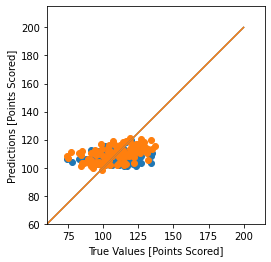

In [12]:
team1_abbreviation = str(input("What is the abbreviation of the 1st team that is playing: "))
team2_abbreviation = str(input("What is the abbreviation of the 2nd team that is playing: "))

team1 = Team(team1_abbreviation)
team2 = Team(team2_abbreviation)

team1_data = team1.get_active_team_data() 
team2_data = team2.get_active_team_data() 

team1_prediction_class = Prediction(team1_data)
team2_prediction_class = Prediction(team2_data)



print("--------------------------Prediction for {}--------------------------".format(team1_abbreviation))

team1_prediction_data = team1.get_data_for_prediction(team2_abbreviation)
team1_prediction, team1_margin = team1_prediction_class.make_prediction(team1_prediction_data)

      
print("--------------------------Prediction for {}--------------------------".format(team2_abbreviation))

team2_prediction_data = team2.get_data_for_prediction(team1_abbreviation)
team2_prediction, team2_margin = team2_prediction_class.make_prediction(team2_prediction_data)

print("-------------------------------------------------------------------------------------------------")
print("{} is predicted to score: {} ± {}".format(team1_abbreviation, team1_prediction, team1_margin))
print("{} is predicted to score: {} ± {}".format(team2_abbreviation, team2_prediction, team2_margin))

print("-------------------------------------------------------------------------------------------------")

